## XGBoost

In [18]:
# ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# エンコーディング
from sklearn.preprocessing import OrdinalEncoder

# model selection
from sklearn.model_selection import train_test_split

# XGBoost
from xgboost import XGBClassifier

In [19]:
# データ準備
df = sns.load_dataset('titanic')

# 単純に欠損値のあるデータを消す
df.dropna(inplace=True)
# X, yを作成 loc[行:列]
X = df.loc[:, (df.columns!='survived') & (df.columns!= 'alive')]
y = df['survived']
# ラベルエンコーディング
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
oe.set_output(transform='pandas')  # デフォルトだとnumpy配列で出力されるから、dfの形に変える。
X = oe.fit_transform(X)
# 学習データを分ける。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


## XGBoost

In [20]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.01,
              eval_metric='auc',
              early_stopping_rounds=10,
              importance_type='total_gain',
              random_state=0)

# early_stoppingを設定しているから、eval_set, verboseを指定する必要あり
# 本来はtestではなくて、検証データをする。また、５Foldなどを実行するのがおすすめ。

# 学習
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-auc:0.85497
[1]	validation_0-auc:0.85497


[2]	validation_0-auc:0.85497
[3]	validation_0-auc:0.86298
[4]	validation_0-auc:0.86298
[5]	validation_0-auc:0.86058
[6]	validation_0-auc:0.86058
[7]	validation_0-auc:0.86058
[8]	validation_0-auc:0.86058
[9]	validation_0-auc:0.86538
[10]	validation_0-auc:0.86378
[11]	validation_0-auc:0.86538
[12]	validation_0-auc:0.86538
[13]	validation_0-auc:0.86378
[14]	validation_0-auc:0.87340
[15]	validation_0-auc:0.86699
[16]	validation_0-auc:0.87340
[17]	validation_0-auc:0.87500
[18]	validation_0-auc:0.87340
[19]	validation_0-auc:0.87019
[20]	validation_0-auc:0.86699
[21]	validation_0-auc:0.87019
[22]	validation_0-auc:0.87019
[23]	validation_0-auc:0.87019
[24]	validation_0-auc:0.87019
[25]	validation_0-auc:0.87019
[26]	validation_0-auc:0.86699
[27]	validation_0-auc:0.87019


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type='total_gain',
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [21]:
from sklearn.metrics import roc_auc_score
y_pred_xgb = xgb.predict_proba(X_test)
print(f'xgboost AUC : {roc_auc_score(y_test, y_pred_xgb[:, 1])}')

xgboost AUC : 0.875


In [22]:
xgb.feature_importances_

array([0.        , 0.        , 0.1168234 , 0.00336676, 0.        ,
       0.15797192, 0.        , 0.        , 0.        , 0.64561296,
       0.04408471, 0.        , 0.03214021], dtype=float32)

<Axes: >

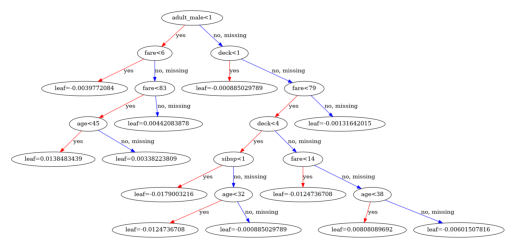

In [23]:
import xgboost
xgboost.plot_tree(xgb, num_trees=0)

In [24]:
import graphviz
print(graphviz.__version__)

0.20.1


### LightBGM

In [25]:
# ライブラリ
import lightgbm as lgb
lgbmc = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)
# データは上のデータ(XGboost)と同様
# 本来は検証データでやるが、今回はデモのためtestデータを使用
eval_set = [(X_test, y_test)]
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())
lgbmc.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 84, number of negative: 43
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total

LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

In [26]:
y_pred_proba = lgbmc.predict_proba(X_test)
print(f'light gbn AUC : {roc_auc_score(y_test, y_pred_proba[:, 1])}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
light gbn AUC : 0.9383012820512822


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

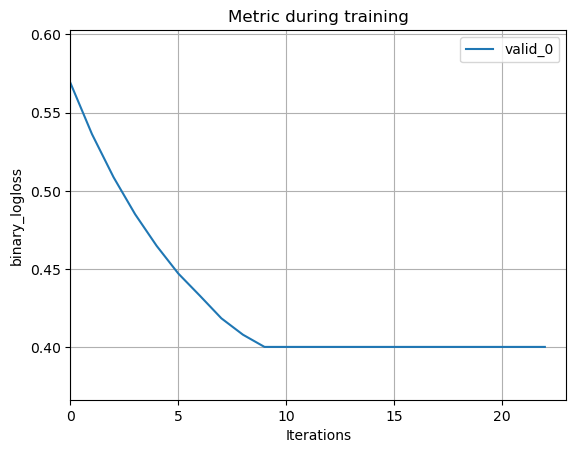

In [27]:
# 学習曲線
lgb.plot_metric(lgbmc)


<Axes: >

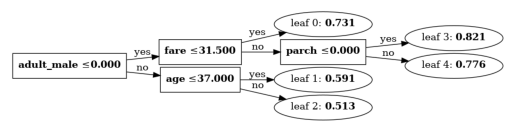

In [28]:
# tree_indexで最初に学習した決定木を見ることができる。
lgb.plot_tree(lgbmc, tree_index=0)

In [29]:
print('hello world')

hello world
